In [1]:
from collections import Counter, defaultdict
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE
import pandas as pd


In [2]:
freqs = pd.read_csv('unigram_freq.csv')
freqs.columns = ['word', 'freq']



In [3]:
from nltk.stem.lancaster import LancasterStemmer 
stemmer = LancasterStemmer()

freqs['word'] = freqs['word'].map(lambda x: stemmer.stem(str(x)))
freqs['freq'] = freqs.groupby(['word'])['freq'].transform('sum')
freqs = freqs.drop_duplicates()
freqs = freqs.reset_index()

In [4]:
freqs.iterrows()

<generator object DataFrame.iterrows at 0x000001F4D6EC0F90>

In [33]:
class SunhoVecDataset:
    def __init__(self, df, n_words=10000, window_size=5):
        self._window_size = window_size
        df = df.iloc[:n_words, :]
        self._word2id = {row['word']:i for i, row in df.iterrows()}
        self._id2word = {i:row['word'] for i, row in df.iterrows()}
        self._id2freq = {i:row['freq'] for i, row in df.iterrows()}
        self._create_delta_matrix()

    def _create_delta_matrix(self):
        
        self._i_idx = list()
        self._j_idx = list()
        self._xij = list()
        
        for i, cnti in enumerate(self._id2freq):
            for j, cntj in enumerate(self._id2freq):
                self._i_idx.append(i)
                self._j_idx.append(j)
                self._xij.append(abs(cnti-cntj))

        self._i_idx = torch.LongTensor(self._i_idx).cuda()
        self._j_idx = torch.LongTensor(self._j_idx).cuda()
        self._xij = torch.FloatTensor(self._xij).cuda()

    def get_batches(self, batch_size):
        #Generate random idx
        rand_ids = torch.LongTensor(np.random.choice(len(self._xij), len(self._xij), replace=False))

        for p in range(0, len(rand_ids), batch_size):
            batch_ids = rand_ids[p:p+batch_size]
            yield self._xij[batch_ids], self._i_idx[batch_ids], self._j_idx[batch_ids]
dataset = SunhoVecDataset(freqs)

In [222]:


EMBED_DIM = 300
class GloveModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(GloveModel, self).__init__()
        self.wi = nn.Embedding(num_embeddings, embedding_dim)
        self.wj = nn.Embedding(num_embeddings, embedding_dim)
        self.bi = nn.Embedding(num_embeddings, 1)
        self.bj = nn.Embedding(num_embeddings, 1)

        self.wi.weight.data.uniform_(-1, 1)
        self.wj.weight.data.uniform_(-1, 1)
        self.bi.weight.data.zero_()
        self.bj.weight.data.zero_()

    def forward(self, i_indices, j_indices):
        w_i = self.wi(i_indices)
        w_j = self.wj(j_indices)
        b_i = self.bi(i_indices).squeeze()
        b_j = self.bj(j_indices).squeeze()

        x = torch.sum(w_i * w_j, dim=1) 

        return x
glove = GloveModel(10000, EMBED_DIM)
glove.cuda()

GloveModel(
  (wi): Embedding(10000, 300)
  (wj): Embedding(10000, 300)
  (bi): Embedding(10000, 1)
  (bj): Embedding(10000, 1)
)

In [223]:
def weight_func(x, x_max, alpha):
    wx = (x/x_max)**alpha
    wx = torch.min(wx, torch.ones_like(wx))
    return wx.cuda()

def wmse_loss(weights, inputs, targets):
    loss = weights * F.mse_loss(inputs, targets, reduction='none')
    return torch.mean(loss).cuda()

In [224]:
total = freqs.iloc[:10000]['freq'].sum()
total =  torch.tensor(total).cuda()
one =  torch.tensor(1.0).cuda()

In [227]:
optimizer = optim.Adagrad(glove.parameters(), lr=0.05)



N_EPOCHS = 1
BATCH_SIZE = 2048
X_MAX = 100
ALPHA = 0.75
n_batches = int(len(dataset._xij) / BATCH_SIZE)
loss_values = list()
for e in range(1, N_EPOCHS+1):
    batch_i = 0

    for x_ij, i_idx, j_idx in dataset.get_batches(BATCH_SIZE):

        batch_i += 1

        optimizer.zero_grad()

        outputs = glove(i_idx, j_idx)
        weights_x = weight_func(x_ij, X_MAX, ALPHA)
        #loss = wmse_loss(weights_x, outputs, torch.log(1+x_ij)-total)
        loss =  F.mse_loss(outputs, torch.log(1-x_ij/total))
        loss.backward()

        optimizer.step()

        loss_values.append(loss.item())

        if batch_i % 100 == 0:
            print("Epoch: {}/{} \t Batch: {}/{} \t Loss: {}".format(e, N_EPOCHS, batch_i, n_batches, np.mean(loss_values[-20:])))  

    print("Saving model...")
    torch.save(glove.state_dict(), "text8.pt")

Epoch: 1/1 	 Batch: 100/48828 	 Loss: 0.22523941844701767
Epoch: 1/1 	 Batch: 200/48828 	 Loss: 0.20397045686841012
Epoch: 1/1 	 Batch: 300/48828 	 Loss: 0.1792476810514927
Epoch: 1/1 	 Batch: 400/48828 	 Loss: 0.15700465589761733
Epoch: 1/1 	 Batch: 500/48828 	 Loss: 0.14112211763858795
Epoch: 1/1 	 Batch: 600/48828 	 Loss: 0.12651823386549949
Epoch: 1/1 	 Batch: 700/48828 	 Loss: 0.1133775357156992
Epoch: 1/1 	 Batch: 800/48828 	 Loss: 0.10206601209938526
Epoch: 1/1 	 Batch: 900/48828 	 Loss: 0.09339414127171039
Epoch: 1/1 	 Batch: 1000/48828 	 Loss: 0.08408966585993767
Epoch: 1/1 	 Batch: 1100/48828 	 Loss: 0.07797049731016159
Epoch: 1/1 	 Batch: 1200/48828 	 Loss: 0.072500691562891
Epoch: 1/1 	 Batch: 1300/48828 	 Loss: 0.06644320227205754
Epoch: 1/1 	 Batch: 1400/48828 	 Loss: 0.061989014782011506
Epoch: 1/1 	 Batch: 1500/48828 	 Loss: 0.057266423106193544
Epoch: 1/1 	 Batch: 1600/48828 	 Loss: 0.053149855136871337
Epoch: 1/1 	 Batch: 1700/48828 	 Loss: 0.04902039580047131
Epoch: 

Epoch: 1/1 	 Batch: 13700/48828 	 Loss: 0.0007900388998677954
Epoch: 1/1 	 Batch: 13800/48828 	 Loss: 0.000773019201005809
Epoch: 1/1 	 Batch: 13900/48828 	 Loss: 0.000768317305482924
Epoch: 1/1 	 Batch: 14000/48828 	 Loss: 0.000752432004082948
Epoch: 1/1 	 Batch: 14100/48828 	 Loss: 0.0007414838706608862
Epoch: 1/1 	 Batch: 14200/48828 	 Loss: 0.0007263643376063556
Epoch: 1/1 	 Batch: 14300/48828 	 Loss: 0.0007188871531980112
Epoch: 1/1 	 Batch: 14400/48828 	 Loss: 0.000701400259276852
Epoch: 1/1 	 Batch: 14500/48828 	 Loss: 0.0006924387009348721
Epoch: 1/1 	 Batch: 14600/48828 	 Loss: 0.0006749990890966729
Epoch: 1/1 	 Batch: 14700/48828 	 Loss: 0.0006560595997143537
Epoch: 1/1 	 Batch: 14800/48828 	 Loss: 0.0006538767862366513
Epoch: 1/1 	 Batch: 14900/48828 	 Loss: 0.000643474658136256
Epoch: 1/1 	 Batch: 15000/48828 	 Loss: 0.0006293960061157123
Epoch: 1/1 	 Batch: 15100/48828 	 Loss: 0.000616982945939526
Epoch: 1/1 	 Batch: 15200/48828 	 Loss: 0.000596690719248727
Epoch: 1/1 	 Ba

Epoch: 1/1 	 Batch: 26900/48828 	 Loss: 0.00013198978995205836
Epoch: 1/1 	 Batch: 27000/48828 	 Loss: 0.00013130786610418
Epoch: 1/1 	 Batch: 27100/48828 	 Loss: 0.0001287511233385885
Epoch: 1/1 	 Batch: 27200/48828 	 Loss: 0.00012710071423498447
Epoch: 1/1 	 Batch: 27300/48828 	 Loss: 0.00012535622554423753
Epoch: 1/1 	 Batch: 27400/48828 	 Loss: 0.00012463141974876634
Epoch: 1/1 	 Batch: 27500/48828 	 Loss: 0.00012454238312784583
Epoch: 1/1 	 Batch: 27600/48828 	 Loss: 0.0001252799957001116
Epoch: 1/1 	 Batch: 27700/48828 	 Loss: 0.00012131861622037832
Epoch: 1/1 	 Batch: 27800/48828 	 Loss: 0.00011957554161199369
Epoch: 1/1 	 Batch: 27900/48828 	 Loss: 0.00011857030549435876
Epoch: 1/1 	 Batch: 28000/48828 	 Loss: 0.0001176990659587318
Epoch: 1/1 	 Batch: 28100/48828 	 Loss: 0.00011660144191409927
Epoch: 1/1 	 Batch: 28200/48828 	 Loss: 0.00011596580952755176
Epoch: 1/1 	 Batch: 28300/48828 	 Loss: 0.00011568359695957042
Epoch: 1/1 	 Batch: 28400/48828 	 Loss: 0.0001149738476669881

Epoch: 1/1 	 Batch: 40100/48828 	 Loss: 4.4146559775981584e-05
Epoch: 1/1 	 Batch: 40200/48828 	 Loss: 4.3877896860067264e-05
Epoch: 1/1 	 Batch: 40300/48828 	 Loss: 4.357068301032996e-05
Epoch: 1/1 	 Batch: 40400/48828 	 Loss: 4.307171402615495e-05
Epoch: 1/1 	 Batch: 40500/48828 	 Loss: 4.310521435400005e-05
Epoch: 1/1 	 Batch: 40600/48828 	 Loss: 4.2405803833389653e-05
Epoch: 1/1 	 Batch: 40700/48828 	 Loss: 4.2257615132257345e-05
Epoch: 1/1 	 Batch: 40800/48828 	 Loss: 4.1844658517220525e-05
Epoch: 1/1 	 Batch: 40900/48828 	 Loss: 4.1861558020173104e-05
Epoch: 1/1 	 Batch: 41000/48828 	 Loss: 4.185537072771694e-05
Epoch: 1/1 	 Batch: 41100/48828 	 Loss: 4.138389358558925e-05
Epoch: 1/1 	 Batch: 41200/48828 	 Loss: 4.109987603442278e-05
Epoch: 1/1 	 Batch: 41300/48828 	 Loss: 3.99545659092837e-05
Epoch: 1/1 	 Batch: 41400/48828 	 Loss: 4.054561832163017e-05
Epoch: 1/1 	 Batch: 41500/48828 	 Loss: 4.0590645221527664e-05
Epoch: 1/1 	 Batch: 41600/48828 	 Loss: 3.990582790720509e-05
Ep

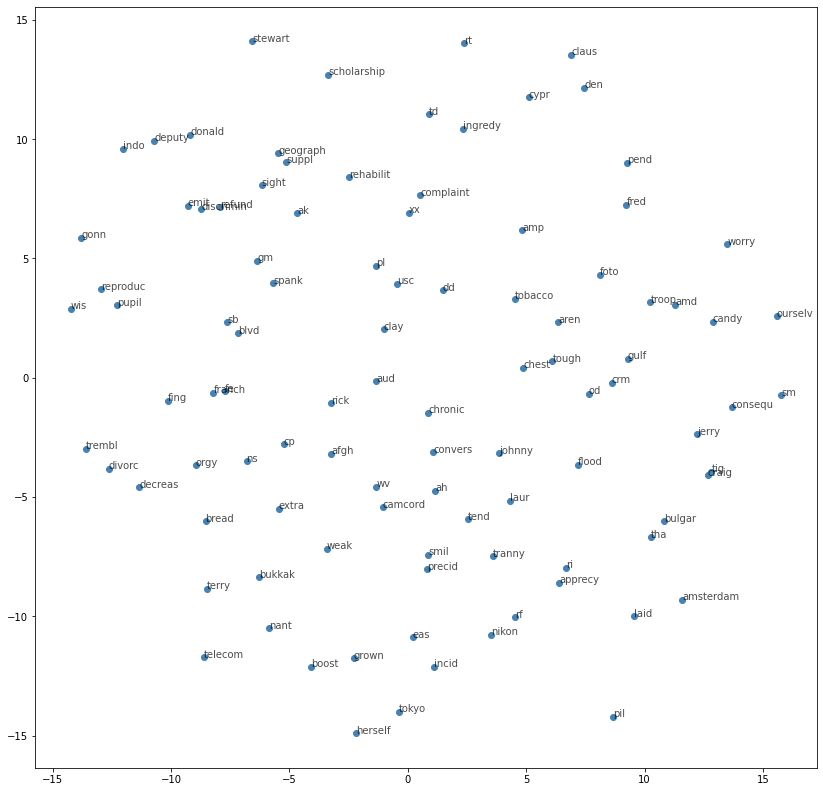

In [228]:
emb_i = glove.wi.weight.cpu().data.numpy()
emb_j = glove.wj.weight.cpu().data.numpy()
emb = emb_i + emb_j
top_k = 3000
tsne = TSNE(metric='cosine', random_state=123)
embed_tsne = tsne.fit_transform(emb[top_k:top_k+300, :])
fig, ax = plt.subplots(figsize=(14, 14))
for idx in range(100):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(dataset._id2word[idx+top_k], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [231]:
total = freqs.iloc[:10000]['freq'].sum()
emb = emb /2

In [209]:
np.log(total)

27.047824730723622

In [234]:
def xi(x,y):
    print(dataset._id2word[x])
    print(dataset._id2word[y])
    print(np.exp(emb_i[x].dot(emb_j[y])))
    print(1-abs(dataset._id2freq[x]-dataset._id2freq[y])/total)

xi(1,4000)

of
tanzan
0.99976516
0.9764478821208485
